## cocoCity - Final Project

### Setup

In [29]:
%env SUMO_HOME=/usr/share/sumo 
# DO NOT TOUCH THE ABOVE LINE: needed for SUMO, which supports the traffic simulation

import os,sys,json,argparse
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import time

# import necessary modules # src is short for "source code", and is a folder that you are given

# The following package is used to estimate the macroscopic fundamental diagram
from src.tasks.estimate import Estimate # Used to estimate the macroscopic fundamental diagram
from src.simulations.testcontrolsim import test_ControlSim # (helper function, can be ignored)

# The following packages are for simulation and control design
from src.tasks.dsl import DSL # DSL is the class used for Dynamic Speed Limit control which runs a ControlSim simulation with Controller in the loop
from src.controllers.controller import Controller # An abstract class for the controllers implemented which determine the dynamic speed limits
from src.simulations.controlsim import ControlSim # A simulation environment in which we test our controllers

# The following packages are for visualization
from src.visualization.visualization import *
from src.data.comparison import Comparison
from src.data.experiment import Experiment

# Load the parameters of the simulation
taskparams_json = "dep/sumo_files/cocoCity/simparams/cocoCity.json"
with open(taskparams_json,'r') as file:
    taskparams = json.load(file)
mfd_taskparams = "dep/sumo_files/cocoCity/simparams/cocoCity_mfd.json"
with open(mfd_taskparams,'r') as file:
    mfd_taskparams = json.load(file)

env: SUMO_HOME=/usr/share/sumo


### Traffic Inflow Problem

You are a control engineer hired by COCO City to improve the flow of traffic in COCO City during the morning rush hour.

#### COCO City's Traffic Grid

The COCO City traffic grid is divided into 5 regions including the periphery regions (Regions 0 to 3) and the city-center region (Region 4).

The 5 roads leading from the periphery regions to the center region (in black) have Dynamic Speed Limit (DSL) functionality that allows COCO City to adjust the speed limits on those roads in real-time.

<img src="figs/COCOcityImage.png" width="800">

The control levers are the dynamic speed limits (DSLs) of the five roads leading to the center region (the black roads numbered 0-4 in the figure above). Each DSL control lever is a number between 0.5 and 1.5 which multiplies the nominal speed limit of 50 km/h to determine the DSL for the given road.

COCO City has hired you to design an algorithm which takes in 1) the densities of the cars on the road and 2) the forecast of the cars that will spawn in each region in the coming timesteps and determines the DSLs for the five roads leading into the city center.

### COCO City provides you with the following

#### A Simulation of Urban MObility (SUMO) traffic simulator with code to implement their basic controller

SimUlation of Urban Mobility (SUMO) is an open-source traffic simulation package which runs a "microscopic" traffic simulation that allows for control of specific cars, and lights, speed limits. In this project, our code interfaces with the SUMO simulator via DSLs and measures density for each region, the number of vehicles travelled, travel time, CO2 emissions, and a few other metrics.

Each simulation timestep corresponds to 20 seconds of wall-clock time.

When COCO City's controller is running, the code interfaces with SUMO to start and stop simulations and to control road speed limits at each simulation step. The code is object-oriented. "tasks" are abstract classes which support subclasses such as a "DSL" task, which run a DSL-control simulation. When a task is instantiated, the code creates a simulation of the traffic network with details specified in the task parameters/function inputs.

A DSL task creates a simulation object called ControlSim, which contains functionality to run the DSL traffic system simulation while continuously adjusting speed limits on specific roads with control logic that you define. The specifics for how to implement a new controller are given in the "How to implement a controller" section below.


                                                                                                                                                                                                                                                                                                                                                                                   

#### The optimal densities for each region, derived from the Macroscopic Fundamental Diagrams (MFDs)

Research on traffic systems shows that maximum flow is reached at a certain density of cars---when density is too low there are few cars flowing through the network, and when density is too high traffic jams arise, impeding the speed at which vehicles travel. The function mapping density to flow is called the Macroscopic Fundamental Diagram (MFD). The maximum flow occurs at a certain optimal density $\rho^*$. 

COCO City's objective is to maximize the flow of vehicles through the city by adjusting the DSLs up or down. DSLs directly affect the density in a given region, as the change in the number of cars in a given region depends on the speed limits of the roads that enter the region.

The mapping between densities and flows, however, is nonlinear. Thus, it is common in traffic control to track the optimal density for a given region, rather than maximizing flow.

With this in mind, COCO City has run experiments to determine the MFD for their city and gathered the following data for the center region/Region 4 (similar plots are available for regions 0-3). 

<img src="figs/MFD_COCOcity_centerRegion.png" width="600">

From the gathered data, it is evident that the optimal densities are approximately 5.70, 9.83, 10.63, 14.55, and 11.94 for regions 0-4, respectively.

In [30]:
rho_star = np.array([5.70, 9.83, 10.63, 14.55, 11.94])
n_regions = 5

optimal_density = {f"Region {region}": round(rho_star[region],2) for region in range(n_regions)}
print('Optimal Densities:\n', json.dumps(optimal_density, indent=4))

Optimal Densities:
 {
    "Region 0": 5.7,
    "Region 1": 9.83,
    "Region 2": 10.63,
    "Region 3": 14.55,
    "Region 4": 11.94
}


#### Training data gathered from offline traffic simulations with a legacy controller.

COCO City has provided you with training data to support you in developing a data-driven controller. The training data was gathered with a simple P controller which adjusts the DSLs using proportional feedback control to keep the system close to $\rho^*$.

The training data simulation provides, for each timestep,
1) the density of cars in each region, and
2) the number of cars that spawn in each region.

There is also an underlying flow of cars which can be measured (e.g., to build the MFD), but for simplicity the flows are not provided in the training data set (see the MFD section above for an explanation why the density is preferable to flow).

The timeseries for the spawned vehicles for each of the five regions in the training data are:

<img src="figs/spawning_training.png" width="800">

In [31]:
# The pd.read_csv() line below gives io_data, which can be used as data for your data-driven controller
io_data = pd.read_csv(f'./dep/sumo_files/cocoCity/control/edge/io_data.csv')
print(f"Data Columns:\n{io_data.columns.values}") # this line prints the column names of the training data

# # the following code produces the evaluation scenario plot above
# spawnedVehicles = np.load('dep/sumo_files/cocoCity/routing/spawning_training.npy')
# fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
# for region in range(5):
#     axes[region].plot(spawnedVehicles[:,region], color='blue', label = f"Vehicles spawned in Region {region}")
#     axes[region].set_ylabel("# Vehicles")
#     axes[region].legend()
# axes[region].set_xlabel("Simulation Time")

# plt.suptitle("Spawned Vehicles in Each Region")
# plt.tight_layout()
# plt.savefig("spawning_training.png", dpi=300, bbox_inches='tight')
# plt.show()


Data Columns:
['Unnamed: 0' 'Speed limit factor for road 0'
 'Speed limit factor for road 1' 'Speed limit factor for road 2'
 'Speed limit factor for road 3' 'Speed limit factor for road 4'
 'Cars Spawning in Region 0' 'Cars Spawning in Region 1'
 'Cars Spawning in Region 2' 'Cars Spawning in Region 3'
 'Cars Spawning in Region 4' 'Density in Region 0' 'Density in Region 1'
 'Density in Region 2' 'Density in Region 3' 'Density in Region 4']


#### Linear traffic model

COCO City has also provided you with a linear state-space approximation of their system dynamics, to support you in developing a model-based controller.

The linear state space linearization, developed internally, approximates how the DSL ratios ($v$) and the spawned vehicles ($q$) relate to the densities in each region ($\rho$):
$$
\boldsymbol{\rho}(k+1) = A \boldsymbol{\rho}(k) + B \boldsymbol{v}(k) + C \boldsymbol{q}(k) + d
$$

The linear system is described by the matrices $A$, $B$, $C$, and the vector $d$ which accounts for the offset that arises when linearizing the nonlinear dynamics. The following code demonstrates how to get $A$, $B$, $C$, and $d$ using the code provided to you by COCO City. The nominal linearization point is $\boldsymbol{v}^* = 1$ (corresponding to 50 km/h) and $\boldsymbol{\rho}^*$ corresponding to the optimal densities for each region according to the MFD. (The original dynamics are linear in $q$, and thus a linearization point $q^*$ is not needed.)

COCO City has provided you with a detailed explanation of the linearized dynamics, which can be found in the accompanying COCOcity_LinearizationNotes pdf. It is not critical that you understand the dynamics linearization, but the file is there if you would like to. If you do investigate the linearization, you will find that COCO City has made of approximations to make the linearization tractable. Thus, while the linearization may be useful for model-based controllers, it is not a faithful representation of the system.

In [32]:
# The code below povides the linear traffic model parameters A, B, C, and d

dsl_task = DSL(taskparams, test_ControlSim) 
rho_star = np.array([5.70, 9.83, 10.63, 14.55, 11.94])
v_target = np.ones(5)
v_high = np.ones(5) * 1.5
v_low = np.ones(5) * 0.5
sim_period = 20 # sampling time (fixed)
model = dsl_task.simulation.get_model()
A, B, C, d = model.linearize(sim_period, rho_star, v_target)
Ah, Bh, Ch, dh = model.linearize(sim_period, rho_star, v_high)
Al, Bl, Cl, dl = model.linearize(sim_period, rho_star, v_low)
                               

print("Matrix A:")
display(A)
print("Matrix A HIGH:")
display(Ah)
print("Matrix A LOW:")
display(Al)
print("Matrix B:")
display(B)
print("Matrix C:")
display(C)
print("Vector d:")
display(d)

Matrix A:


array([[0.96144546, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.92674637, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.96144546, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.96144546, 0.        ],
       [0.03052235, 0.06104469, 0.03052235, 0.03052235, 0.9       ]])

Matrix A HIGH:


array([[0.94216818, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.89011955, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.94216818, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.94216818, 0.        ],
       [0.04578352, 0.09156704, 0.04578352, 0.04578352, 0.9       ]])

Matrix A LOW:


array([[0.98072273, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.96337318, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.98072273, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.98072273, 0.        ],
       [0.01526117, 0.03052235, 0.01526117, 0.01526117, 0.9       ]])

Matrix B:


array([[ 0.        , -0.2197609 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.36004161, -0.36004161,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.4098348 ],
       [-0.56096861,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.44410015,  0.17397738,  0.30003467,  0.30003467,  0.32445255]])

Matrix C:


array([[0.00077109, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00073254, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00077109, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00077109, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00061045]])

Vector d:


array([ 0.2197609 ,  0.72008322,  0.4098348 ,  0.56096861, -1.54259943])

#### Evaluation Scenario

COCO City has provided you with the following timeseries of vehicle spawning in each region to evaluate different controllers. Without control, the evaluation scenario leads to gridlock.

<img src="figs/spawning_eval.png" width="800">

For the evaluation, you are given a perfect prediction of the vehicles that will spawn in the future (how the prediction is provided to you is explained below). While it is not realistic to have a perfect forecast (there is always error in predictions), COCO City finds this imperfection acceptable for a proof-of-concept. 

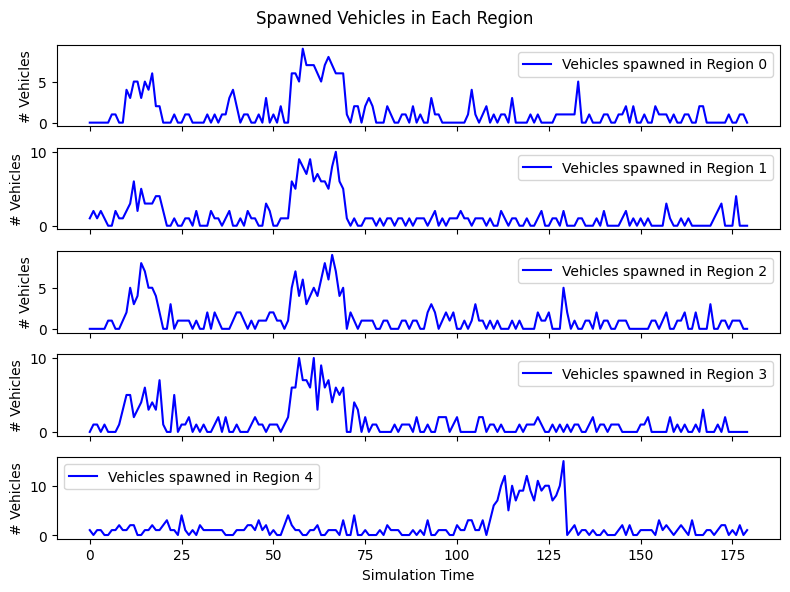

In [33]:
# the following code produces the evaluation scenario plot above
spawnedVehicles = np.load('dep/sumo_files/cocoCity/routing/spawning_evaluation.npy')
fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
for region in range(5):
    axes[region].plot(spawnedVehicles[:,region], color='blue', label = f"Vehicles spawned in Region {region}")
    axes[region].set_ylabel("# Vehicles")
    axes[region].legend()
axes[region].set_xlabel("Simulation Time")

plt.suptitle("Spawned Vehicles in Each Region")
plt.tight_layout()
plt.show()

#### How to implement a controller

As stated in the SUMO background section above, a DSL task creates a simulation object called ControlSim, which contains functionality to run the DSL traffic system simulation while continuously adjusting speed limits on specific roads with control logic that you define. A DSL task takes a ControlSim object, which you define, as an input and runs a simulation when dsl_task.runtask() is called.

The ControlSim object you define (e.g., ControlSim below) is a wrapper for the ControlSim abstract class (defined by/for the SUMO code) and must include a compute_input() function (see below for an example). The compute_input() function takes in a number of inputs (see below) as well as a controller object, which you also define. 

The Controller object you define is a wrapper for the Controller abstract class (a *different* abstract class, also defined by/for the SUMO code) and must include a get_next_input() function (see below for an example). The get_next_input() function is where you will implement the computational controllers that you develop to improve upon COCO City's controller.

To evaluate a given controller, defined for a DSL task when the task in instantiated (see below), the following command is used:
`experiment = dsl_task.runtask()`.
COCO City has built runtask() with the evaluation data set which they use to determine the quality of a given controller. This evaluation data set is similar to the training data provided above, but slightly different and more challenging. Specifically, the training data set leads to gridlock when no control is used. See the demonstration below. Note, the evaluation data should not be used to train a new controller. Rather, the training data (above) should be used.

The code below shows how noControl, which applies the nominal input (DSL of 1), performs on the evaluation set. Notice that at the end of the simulation, the central region is gridlocked and no flow occurs.

In [263]:
class noControl_controller(Controller):
    def __init__(self,actuators,params = {}) -> None:
        '''Initialize the controller'''
        super().__init__(actuators=actuators, params=params)
        self.name='noControl_controller'
        self.example = params['Example']
        
    def get_next_input(self):
        '''
        [CONTROLLER DESCRIPTION]
        -------------------------------
        Inputs: IMPLEMENT
        Outputs: IMPLEMENT
        '''
        u = np.ones(5) # one input for each DSL
        y = np.zeros(5) # one output prediction for each region
        return u, y 
    
class ControlSim(ControlSim):
    def __init__(self,network,taskparams,actuators,controlparams = {}):
        super().__init__(network=network,taskparams=taskparams,actuators=actuators,controlparams=controlparams)

    def compute_input(self, k, forecast, controller, controller_name, 
                      uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix, m, p, rho_opt, u_min, u_max):
        '''
        Compute the input for the controller.

        This function is called "under the hood" of an Unjam traffic simulation/a dsl_task. Thus, the inputs to compute_input are provided automatically. 
        
        COCO City has set up the code so that the following inputs are provided to compute_input for you:
        - forecast, which provides the forecast of the spawned vehicles to be used for predictive control (though some engineering is required to produce y_future), 
        - uAppliedMatrix and yMeasuredMatrix are the matrices of inputs and outputs filled in over the course of a simulation. They can be used as the lead-in data for a data-driven controller (though some engineering is required).
        - ySingleStepPredMatrix is the matrix of single step predictions ySingleStepPred, filled in over the course of a simulation.
        -------------------------------
        **Inputs:
        k: int, discrete time step (each discrete time step corresponds to 20 seconds of wall-clock time)
        forecast: np.array, forecast of spawned vehicles from all 5 regions (including center region) to the center region
        controller: Controller, controller object, defined separately
        controller_name: str, name of the controller
        uAppliedMatrix: np.array, memory of applied control inputs (zeros for timesteps that have not occurred yet)
        yMeasuredMatrix: np.array, memory of outputs (zeros for timesteps that have not occurred yet)
        ySingleStepPredMatrix: np.array, memory of single-step predicted outputs (zeros for timesteps that have not occurred yet)
        m: int, number of actuators
        p: int, number of outputs (1 per region)
        rho_opt: np.array((5,)), optimal density for each of the 5 regions
        u_min: np.array, minimum control input for each actuator (0.5)
        u_max: np.array, maximum control input for each actuator (1.5)
        -------------------------------
        **Returns:
        uApplied: np.array, control input for each actuator (5 actuators) (automatically put into uAppliedMatrix)
        ySingleStepPred: np.array, predicted density for each region (5 regions) (automatically put into ySingleStepPredMatrix)
        '''
        
        if controller_name == 'noControl_controller':
            uApplied, ySingleStepPred = controller.get_next_input()
        elif controller_name == 'anotherMethod_controller':
            pass # implement controller 
        
        return uApplied, ySingleStepPred
        


#### Defining control parameters

When you instatiate a controller, you pass the controller parameters in the form of a dictionary (see {'Example': 5} below).

These parameters include, for example the control cost and regularization parameters.

The parameters may also include the dynamics matrices for the model-based controller, as well as the data driven predictor (Hankel matrix for DeePC, Transient Predictor for TPC) for data-driven controllers.


In [264]:
# for the no control case, no parameters are needed. Below is just an example of how a parameter could be set.
noControl_control_params = {'Example': 5}

In [265]:
# takes around 30s to run
dsl_task = DSL(taskparams, ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class

experiment = dsl_task.runtask(init_from_notebook=True, controller_class=noControl_controller, controller_json=noControl_control_params) 
# this line will instantiate a SUMO simulation and the specified controller
# The controller is determined by "controller_class" and the parameters are determined by "controller_json"
# runtask starts SUMO (the traffic sim)
# "experiment" is the saved output of the simulation

Running Simulation...
 Retrying in 1 seconds


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (6ms ~= 166.67*RT, ~176666.67UPS, TraCI: 222ms, vehicles TOT 1635 ACT 1060 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


#### Controller evaluation tools

COCO City has provided you with the `Comparison` package to evaluate the performance of controllers. The `Comparison` package includes 

`plot_density()`, 

`plot_flow()`, 

`plot_input()`, and

`plot_metrics()`, which plots the total CO2 emissions, travel time for all vehicles, waiting time for all vehicles, and the number of vehicles which successfully reached their destination.

Additionally and optionally, you have access to the `Experiment` package to load a previously saved simulation using the function `load(output_dir)`. An example of how this can be used is included below. Note that the default output directory of a simulation (`/out/cocoCity/cocoCity/`) will be overwritten at the next experiment. Therefore, if you wish to use previously saved results you are encouraged to copy the output folder and rename it.

COCO City has also provided you with GIF-generating code to visualize the road congestion/densities over the course of a simulation.

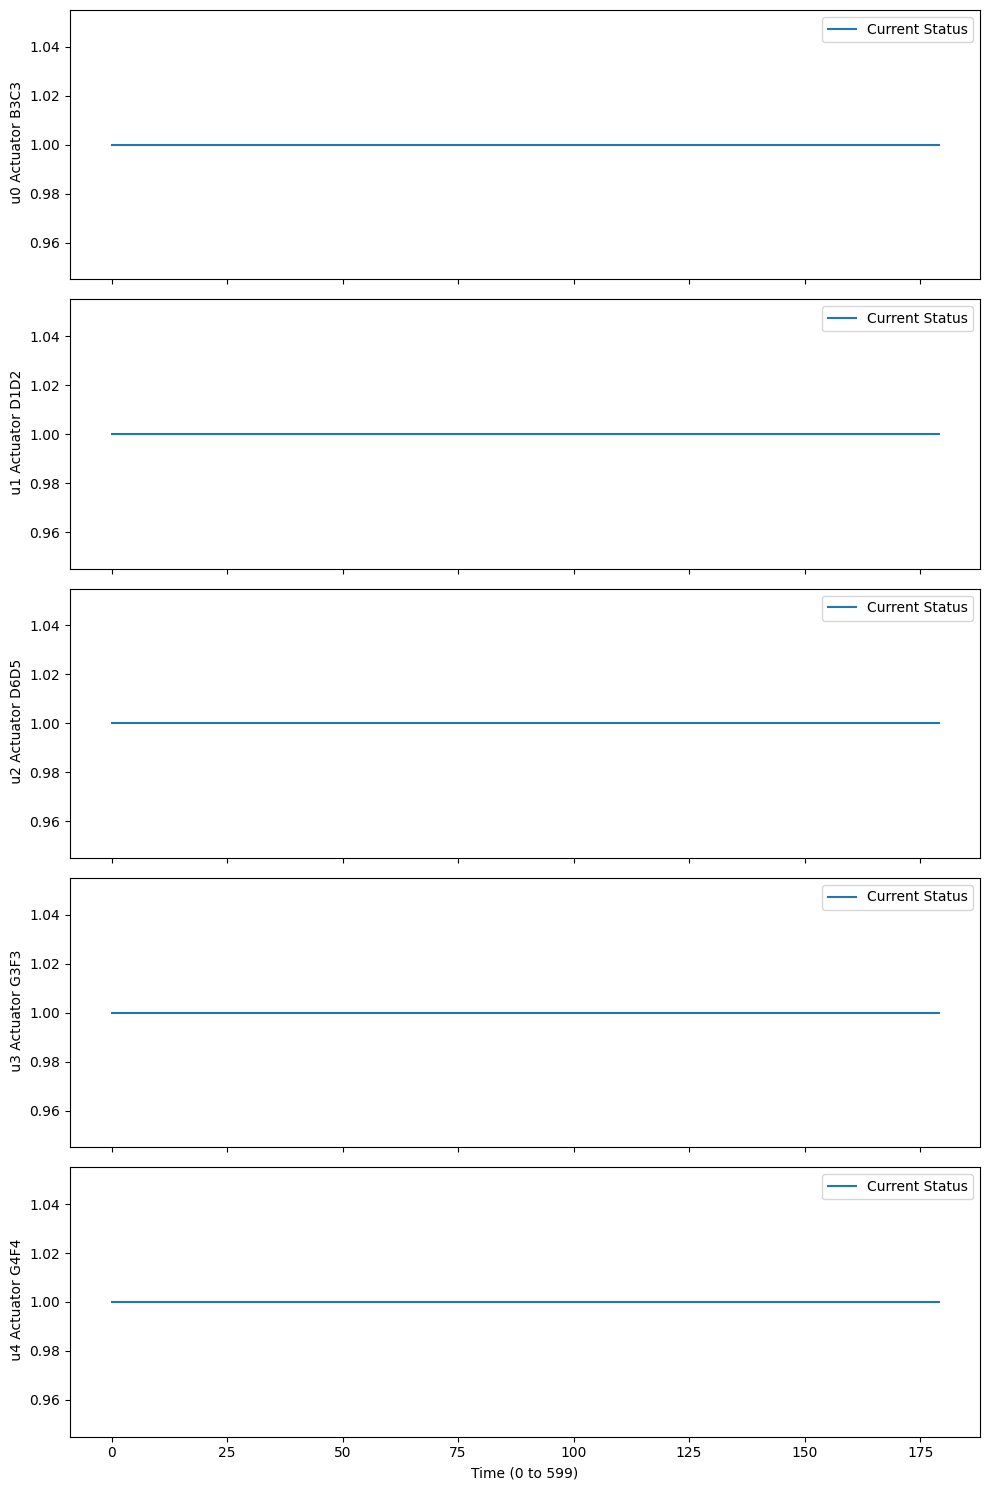

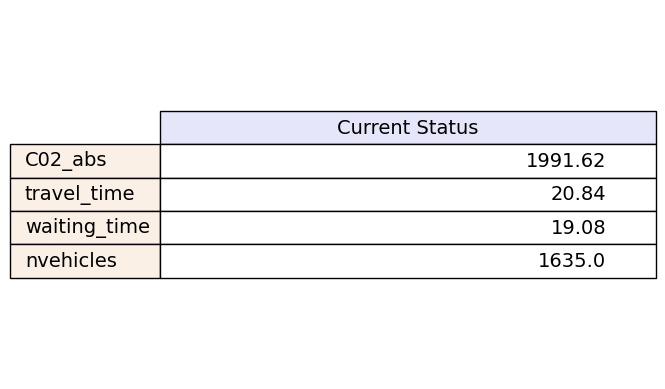

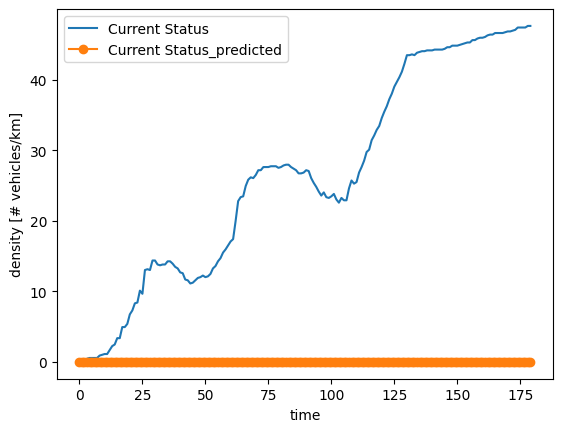

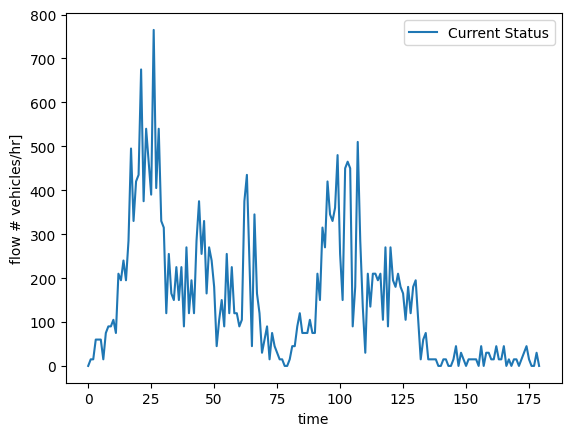

In [266]:
region = 'Region 4'
com = Comparison([experiment], ['Current Status'], region=region)

com.plot_input()
com.plot_metrics()
com.plot_density()
com.plot_flow()

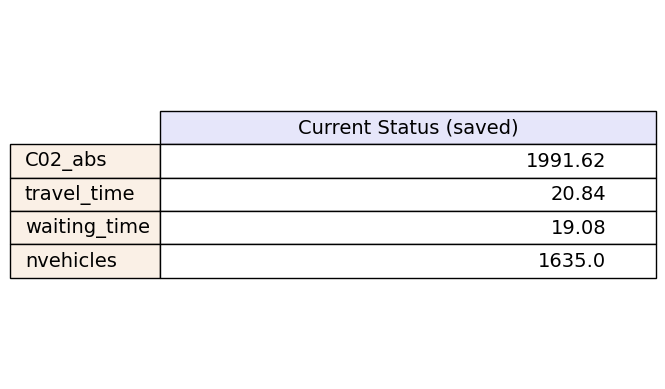

In [12]:
## Alternatively, if you have the saved output_dir, you can also plot the results.
output_dir = experiment.info['output_path']  # This is where the output of the experiment was saved.
experiment_saved = Experiment() # instantiate an empty experiment
experiment_saved.load(output_dir) # Load in the simulation experiment result
com = Comparison([experiment_saved], ['Current Status (saved)'], region=region)
com.plot_metrics()

In [13]:
# GIF Generation
# [DO NOT TOUCH THE LINE BELOW] Turns off matplotlib in-line plotting to save memory, needed for GIF generation.
# %matplotlib agg 

# This takes around 2 minutes (can be commented out)
# (if generated, the gif can also be saved so that it does not have to be generated new each time, or turned off for faster prototyping)
# output_dir = experiment.info['output_path'] # This is where the output of the experiment was saved.
# output_gif_path = "figs/no_control_demo_heatmap.gif"   # Specify where to save the density git file, can change to your own path
# cmap, norm = cocoCity_plot_generate_density_gif(output_dir, output_gif_path) 

# Display saved GIF
# [DO NOT TOUCH THE LINE BELOW] turns matplotlib in-line back on.
# %matplotlib inline
# display(Image(url=output_gif_path))
# plot_color_legend(cmap, norm)

#### COCO City's current status: P control

COCO City currently is running a P controller which keeps the density in the center region close to the optimal density by adjusting the DSLs proportionally to the error between the center-region density and the optimal density. The following block diagram describes how $\rho$ feedback loop is used to adjust the DSLs by the COOC City P control.

<img src="figs/COCOcity_pController.png" width="600">

The factor that multiplies 50 km/h for each road is $u = 1 + K_p e$, where $e = \rho_4 - \rho_4^*$. The max $u$ is 1.5, corresponding to 75 km/h, and the minimum speed limit is 0.5, corresponding to 25 km/h. That is, the speed for each DSL is $50 + 50 K_p (\rho_4 - \rho_4^*)$, clipped at 25 and 75 km/h.

The P control is demonstrated below.

In [14]:
# First, the P controller and the ControlSim is built

class pController(Controller):  
    def __init__(self,actuators,params={}) -> None:
        '''Initialize the controller'''
        super().__init__(actuators,params)
        self.name='P'
        self.n_regions = params['n_regions']
    
        self.ul = self.safety[0] # lower bound on the input = 0.5
        self.uu = self.safety[1] # upper bound on the input = 1.5
    
        self.Kp = params['Kp']
    
    def get_next_input(self, n, target_region, r):
        '''Derive and check the inputs from the optimization
        Args:
            n: Current densities
            T: Current time
        Returns:
            Next inputs 
        '''
        self.r = r.copy()
        target_region_index = target_region - 1
        n = n.copy()[target_region_index]
        r = self.r.copy()[target_region_index]
    
        error = r - n
        u = 1 + self.Kp * error
    
        u = np.clip(u, self.ul, self.uu)
        
        return np.tile(u, 5)


class pControl_ControlSim(ControlSim):
    def __init__(self,network,taskparams,actuators,controlparams = {}):
        super().__init__(network=network,taskparams=taskparams,actuators=actuators,controlparams=controlparams)

    def compute_input(self, k, forecast, controller, controller_name, uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix, m, p, r, u_min, u_max):
        freq = 5
        if k % freq == 0:
            n = yMeasuredMatrix[:,k]
            target_region = 5
            u = controller.get_next_input(n, target_region, r)
            y = np.zeros(5) # No prediction, just assume it's flat
            return u, y
        else:
            return uAppliedMatrix[k-1,:], ySingleStepPredMatrix[k-1,:]




# Second, the Kp parameter is set and the P controller is simulated on the evaluation sim

pControl_control_params = {'Kp': 0.5}

dsl_task = DSL(taskparams, pControl_ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class
controller_class = pController
controller_json = pControl_control_params
experiment = dsl_task.runtask(init_from_notebook=True, controller_class=controller_class, controller_json=controller_json)
# runtask starts SUMO (the traffic sim)
# "experiment" is the saved output of the simulation



# Third, the relevant metrics and timeseries are plotted

region = 'Region 4'
com = Comparison([experiment], ['Current Status'], region=region)



Running Simulation...
 Retrying in 1 seconds


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (7ms ~= 142.86*RT, ~136285.71UPS, TraCI: 192ms, vehicles TOT 1649 ACT 954 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


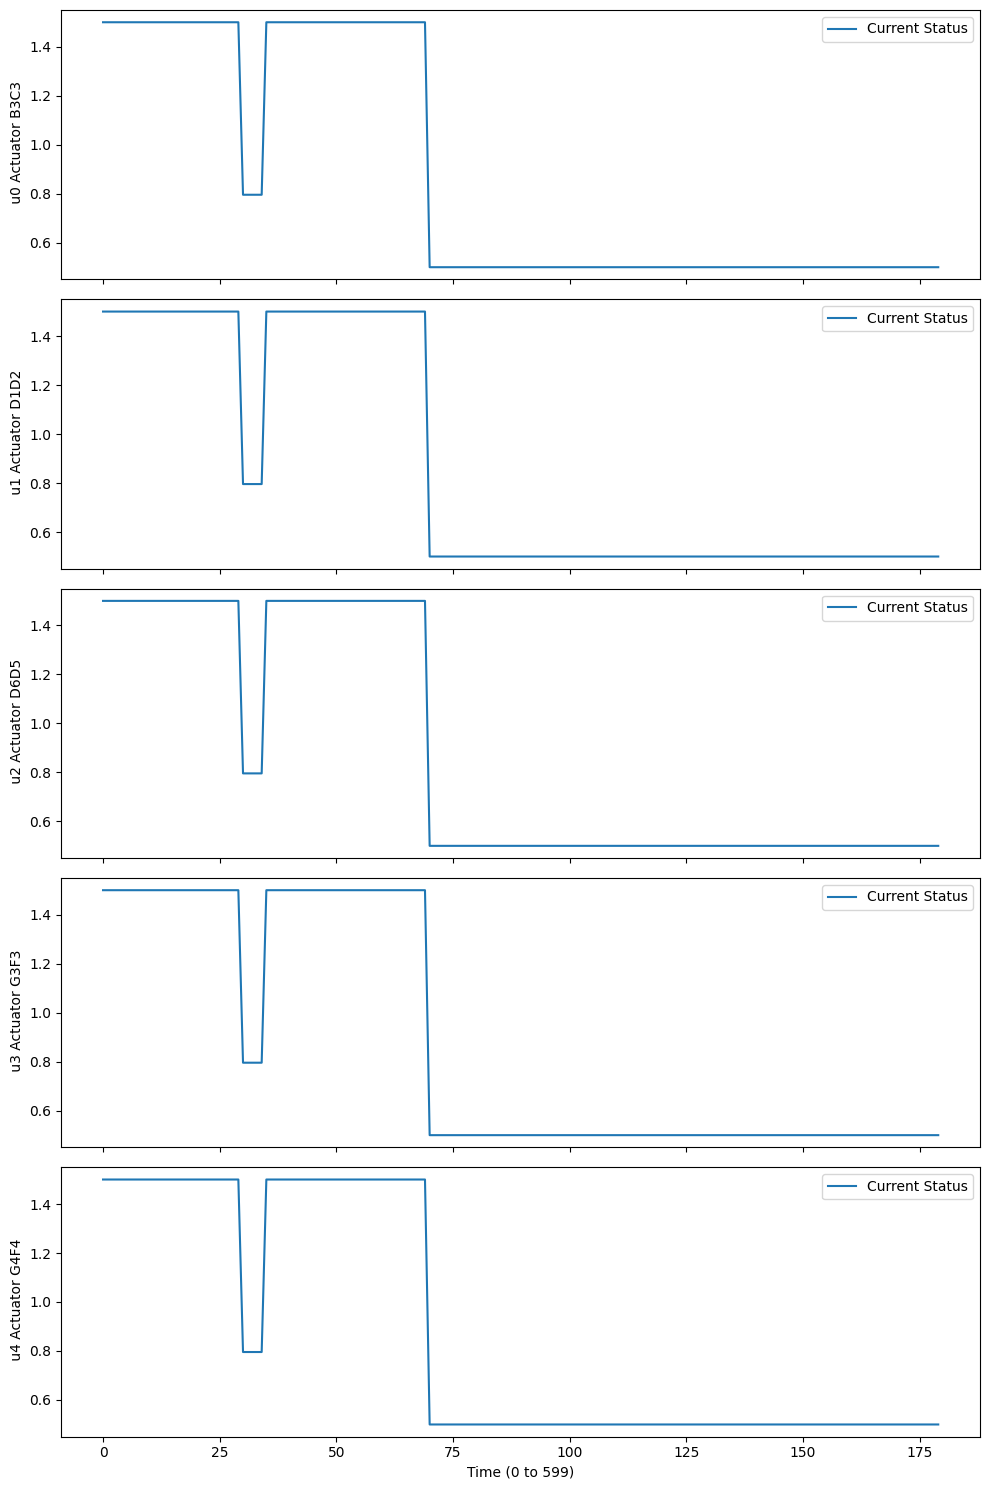

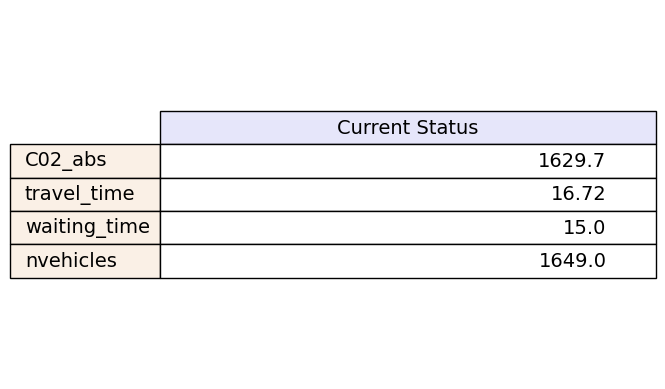

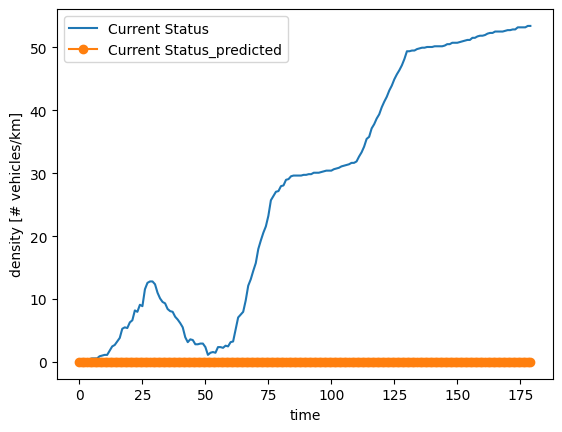

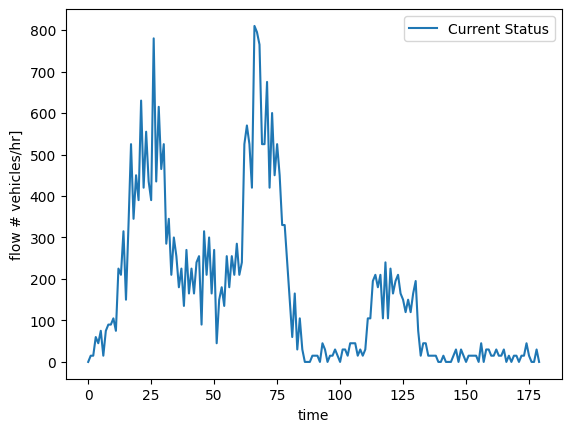

In [15]:
com.plot_input()
com.plot_metrics()
com.plot_density()
com.plot_flow()

As you can see in the performance metrics and density and flow timeseries above, the P controller performs better than no control but does not avoid gridlock at the end of the simulation.

# Your task

You are hired by COCO City to improve on the existing traffic control performance. 

To facilitate this, COCO City has provided you with the training data above, intended to be used with a data-driven controller, and the linearization parameters $A$, $B$, $C$, and $d$ above, intended to be used with a Model Predictive Controller.

COCO City does not know which controller will perform best, and are reliant upon you to provide a controller that improves performance and (hopefully) avoids gridlock in their downtown area.

To solve the optimization problem, we advise you to use the MOSEK solver (`problem.solve(solver=cp.MOSEK`), though you are welcome to use other solvers.
Implement your code below.

# ReadMe

### Project Overview

This notebook implements and evaluates two traffic control approaches for COCO City’s traffic grid:

- **Model Predictive Controller (MPC)**
- **Data-enabled Predictive Controller (DeePC)**

The goal is to regulate the traffic densities across the 5 regions and avoid gridlock.

---

### Model-Based Controller (MPC)

#### Implementation

The MPC controller solves a finite-horizon quadratic program using the linearized state-space model provided by COCO City:

$$
\rho(k+1) = A \rho(k) + B v(k) + C q(k) + d
$$


The controller optimizes over both state tracking and input smoothness, solving for control inputs that minimize deviations from the optimal densities (rho_star).
To relax the computational requirements, only every 8 step a new input is calculated. For the following steps, the input is kept constant. 

#### Tunable Parameters

- `horizon`: MPC prediction horizon length (set to 100)
- `Q`: state penalty matrix (selected to slightly emphasize Region 4)
- `R`: input delta penalty matrix (small penalties for smooth control)
- `beta`: discount factor (0.97)
- `frequency`: How often the input is recomputed. 

#### Parameter Tuning Process

The parameters were tuned using a grid search first, followed by manual experimentation:

- `Q` was adjusted to give slightly more weight to the city center region (Region 4), as it is most prone to gridlock.
- `R` was kept small to allow flexibility in control input changes.
- `horizon` was chosen to provide sufficient future visibility without excessive computation.
- `beta` close, but slightly less than 1 helps the controller to focus on immediate actions rather than solving arrising problems at a later time. 

All parameter values ensure the problem solves efficiently within the 5-minute runtime constraint.

---

### Data-Driven Controller (DeePC)

#### Implementation

The DeePC controller uses historical trajectory data to build Hankel matrices that implicitly capture system dynamics without requiring an explicit model.

It solves a quadratic program at each time step using the collected Hankel matrices to directly predict and control system behavior.

I preprocess all of the historical input-output data by subtracting their long-term averages so that the controller learns to predict only deviations from “typical” behavior—this both improves numerical stability and removes bias. At run-time, I likewise center the most recent measurements before solving the DeePC optimization, then restore a small local offset so predictions stay anchored around the current operating point.  Finally, during the very first two control steps I avoid abrupt, possibly erratic commands by “blending” my simple warm-start guess (e.g. holding the last measured output and unit inputs) with the full DeePC solution via a coefficient α that smoothly goes from 1 down to 0.  The result is a controller that starts up gently and then rapidly switches over to the full, centered predictive model once enough history has been gathered.


#### Tunable Parameters

- `Lp`: length of past trajectory window (20)
- `Lf`: length of future prediction horizon (12)
- `hankel_cols`: number of Hankel columns (350)
- `Q`: output weights
- `R`: input weights
- `lambda_g`: regularization for Hankel coefficients

#### Parameter Tuning Process

The parameters were tuned using a grid search first, followed by manual experimentation:

- `Lp` and `Lf` were chosen based on both the amount of available training data and the complexity of the system. A past horizon Lp=20 allows the controller to capture sufficient historical behavior while avoiding overfitting to noise. A future horizon Lf=12 was selected to give the controller sufficient foresight for planning, while keeping the optimization problem computationally tractable.
- `lambda_g` was increased to 5000 to add stronger regularization on the Hankel coefficients. This helps to prevent the solution from excessively fitting to noise or small variations in the training data, improving generalization and numerical stability of the optimization.
- `Q` and `R` were manually tuned to balance tracking accuracy and control smoothness. The weights in `Q` reflect the relative importance of keeping all regions near their optimal density targets, while assigning slightly less aggressive weight to Region 4 compared to the MPC. The `R` matrix penalizes large input changes, promoting smoother control actions.
- `hankel_cols` defines the size of the Hankel matrix. Chosen relatively large to avoid infesability, at the cost of higher computation time, but still within the limits. 
---

### Bonus Controller

No bonus controller was implemented in this submission.

---

### Simulation Runtime

All experiments complete within approximately 3.5 minutes, comfortably within the allowed 5-minute runtime.

---

### Summary

Both controllers were implemented using the COCO City infrastructure with no code breaking changes. All results, metrics, and plots are automatically generated within this notebook upon execution.


# Model Based Controller: MPC

In [16]:
# --- Model Predictive Controller (MPC) Implementation ---

# Define the MPC Controller class
class mpcController(Controller):
    """
    Model Predictive Controller (MPC) for traffic control in COCO City.

    Attributes:
        n_regions (int): Number of controlled regions.
        ul (float): Lower bound on control input.
        uu (float): Upper bound on control input.
        beta (float): Discount factor for cost function.
        A, B, C (np.array): System dynamics matrices.
        d (np.array): Constant system offset.
        N (int): Prediction horizon.
        Qmat, Rmat (np.array): Weight matrices for state and input penalties.
    """
    def __init__(self, actuators, params):
        super().__init__(actuators, params)
        self.name = 'MPC'
        self.n_regions = params['n_regions']

        # Extract safety bounds
        self.ul, self.uu = self.safety  

        # Discount factor for stage cost
        self.beta = params.get('discount', 0.97)

        # System dynamics
        self.A, self.B, self.C = params['A'], params['B'], params['C']
        self.d = params['d'].flatten()

        # Prediction horizon
        self.N = params['horizon']

        # Weight matrices for cost function
        self.Qmat = np.diag(params['Q'])
        self.Rmat = np.diag(params['R'])
        
    def get_next_input(self, n, r, spawn_seq, freq, u_past, k):
        """
        Computes optimal control input using MPC optimization.

        Args:
            n (np.array): Current density vector (shape: 5,).
            r (np.array): Reference density vector (shape: 5,).
            spawn_seq (np.array): Forecasted spawn sequence (shape: N,5).
            freq (int): Control update frequency.
            u_past (np.array): Previous control input (shape: 5,).
            k (int): Current time step.

        Returns:
            uq (np.array): Control input to apply (shape: 5,).
            xq (np.array): Predicted state for next step (shape: 5,).
        """
        hor = min(self.N, spawn_seq.shape[0])  # actual horizon length
        U = cp.Variable((hor, self.n_regions))
        X = cp.Variable((hor + 1, self.n_regions))

        cost = 0
        constr = []

        # Initial state constraint
        constr += [X[0, :] == n]

        # Print progress every 40 iterations (for monitoring long simulations)
        if k % 40 == 0: 
            print("Progress:", round(k / 1.7, 1), "%")

        for t in range(hor):
            w_t = spawn_seq[t, :]
            # System dynamics constraint
            constr += [
                X[t + 1, :] == (self.A @ X[t, :]) + (self.B @ U[t, :]) + self.d + (self.C @ w_t)
            ]

            # Control input bounds (safety constraints)
            constr += [self.ul <= U[t, :], U[t, :] <= self.uu]

            # Stage cost (state deviation penalty)
            stage_weight = self.beta ** t
            cost += stage_weight * cp.quad_form(X[t + 1, :] - r, self.Qmat)

            # Input delta penalty (smoothness)
            delta_u = U[t, :] - (u_past if t == 0 else U[t - 1, :])
            cost += cp.quad_form(delta_u, self.Rmat)

        # Define and solve optimization problem
        prob = cp.Problem(cp.Minimize(cost), constr)
        prob.solve(solver=cp.MOSEK)

        # Extract optimal control input and next predicted state
        uq = U.value[0, :]
        xq = X.value[1, :]
        return uq, xq


# --- Simulation interface for MPC controller ---

class MPC_ControlSim(ControlSim):
    """
    Simulation interface to execute MPC controller during closed-loop simulation.
    """
    def compute_input(self, k, forecast, controller, controller_name,
                      uAppliedMatrix, yMeasuredMatrix,
                      ySingleStepPredMatrix, m, p, r, u_min, u_max):

        freq = 8  # control frequency (solve every 8 steps)
        step = k % freq

        if step == 0:
            # At update step: solve optimization
            n = yMeasuredMatrix[:, k]
            seq = forecast[k:, :]
            u_prev = uAppliedMatrix[k - 1, :] if k > 0 else np.ones(5)
            u, y = controller.get_next_input(n, r, seq, freq, u_prev, k)
            return u, y
        else:
            # Between updates: reuse previous input
            return uAppliedMatrix[k - 1, :], ySingleStepPredMatrix[k - 1, :]


In [17]:
# Second, Parameters and simulation

mpc_params = {
    'n_regions': 5,
    'A':          A,
    'B':          B,
    'C':          C,
    'd':          d,
    'horizon':    100,
    'Q':        [1,1,1,1,1.6],
    'R':      [0.0005,0.0005,0.0005,0.0005,0.0005],
    'discount': 0.97
}
dsl_task = DSL(taskparams, MPC_ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class
controller_class = mpcController
experimentMPC = dsl_task.runtask(
    init_from_notebook=True,
    controller_class=mpcController,
    controller_json=mpc_params
)

Running Simulation...
 Retrying in 1 seconds
Progress: 0.0 %
Progress: 23.5 %


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Progress: 47.1 %
Progress: 70.6 %
Progress: 94.1 %
Step #3580.00 (0ms ?*RT. ?UPS, TraCI: 48ms, vehicles TOT 1703 ACT 45 BUF 0)               
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


# Data Driven Controller

## DeePC

Data-enabled Predictive Control (DeePC) implementation 
for COCO City's traffic-density regulation task.

This controller regulates the center region near rho_star,
while also secondarily regulating the remaining four regions.

It follows the DeePC lecture notes formulation, and fits into 
the same simulation framework as other controllers.

In [18]:
def build_hankel(data: np.ndarray, depth: int) -> np.ndarray:
    """
    Constructs a block Hankel matrix from multivariate time-series data.

    Parameters
    ----------
    data : np.ndarray
        Input data array of shape (n_signals, T), where:
            - n_signals: number of signals (inputs + outputs)
            - T: total number of time steps
        
    depth : int
        Total horizon length (L_p + L_f), i.e. number of columns per trajectory window.

    Returns
    -------
    H : np.ndarray
        Block Hankel matrix of shape (n_signals * depth, T - depth + 1)

    Raises
    ------
    ValueError
        If the requested depth is larger than available data length.
    """
    n, T = data.shape
    N = T - depth + 1  # number of columns in Hankel matrix

    if N <= 0:
        raise ValueError(f"build_hankel: need T ≥ depth, but got T={T}, depth={depth}")

    H = np.empty((n * depth, N))

    for i in range(N):
        # Stack time windows column-wise
        H[:, i] = data[:, i:i + depth].reshape(-1)

    return H

In [19]:
class deePCController(Controller):
    """Data-enabled Predictive Controller for COCO City."""

    def __init__(self, actuators, params):
        super().__init__(actuators=actuators, params=params)
        self.name = "deePC_controller"
        
        # Dimensions & horizons
        self.m, self.p = 5, 5
        self.Lp = params.get("Lp", 20)
        self.Lf = params.get("Lf", 12)
        self.L  = self.Lp + self.Lf
        
        # Weights & regularization
        self.Q = np.diag(params.get("Q", [1, 1, 1, 1, 1]))
        self.R = np.diag(params.get("R", [0.01] * self.m))
        self.lambda_g = params.get("lambda_g", 5e3)
        
        # Actuator limits
        self.u_min = np.full(self.m, params.get("u_min", 0.5))
        self.u_max = np.full(self.m, params.get("u_max", 1.5))
        
        # Load and center data
        df = pd.read_csv('./dep/sumo_files/cocoCity/control/edge/io_data.csv', index_col=0)
        density_cols = [f"Density in Region {i}" for i in range(self.p)]
        speed_cols   = [f"Speed limit factor for road {i}" for i in range(self.m)]
        U_raw = df[speed_cols].values.T  # shape (m, T)
        Y_raw = df[density_cols].values.T  # shape (p, T)
        
        self.u_mean = U_raw.mean(axis=1, keepdims=True)
        self.y_mean = Y_raw.mean(axis=1, keepdims=True)
        
        Uc = U_raw - self.u_mean
        Yc = Y_raw - self.y_mean
        
        # Build Hankel matrices
        max_cols = Uc.shape[1] - self.L + 1
        hankel_cols = min(params.get('hankel_cols', max_cols), max_cols)
        self.H_u = build_hankel(Uc, self.L)[:, :hankel_cols]
        self.H_y = build_hankel(Yc, self.L)[:, :hankel_cols]

    def get_next_input(self, u_hist: np.ndarray, y_hist: np.ndarray, ref: np.ndarray):     
        k = u_hist.shape[0]
        
        if k % 40 == 0: 
            print("Status:", round(k / 1.7, 1), "%")  
        
        # If not enough past data, apply warm start
        if k < self.Lp:
            u0 = np.clip(np.ones(self.m), self.u_min, self.u_max)
            y0 = y_hist[-1] if k else np.zeros(self.p)
            return u0, y0
        
        # Build past data blocks
        u_p = (u_hist[-self.Lp:].T - self.u_mean).flatten()
        y_p = (y_hist[-self.Lp:].T - self.y_mean).flatten()

        self.y_win_mean = y_hist[-self.Lp:].mean(axis=0)
        delta_y = self.y_win_mean - self.y_mean.flatten()

        # Build reference trajectory for prediction horizon
        r_block = np.tile(ref - self.y_win_mean, self.Lf)
        
        # Solve DeePC optimization
        u_f, y_f = self._solve_deepc(u_p, y_p, r_block)
        u0 = u_f[:self.m]
        y0 = y_f[:self.p] + self.y_win_mean

        # Apply blending for smoother transition during early steps
        u0_warm = np.clip(np.ones(self.m), self.u_min, self.u_max)
        y0_warm = y_hist[-1]

        alpha = max(0.0, 1.0 - (k - self.Lp) / 2)
        u0 = alpha * u0_warm + (1 - alpha) * u0
        y0 = alpha * y0_warm + (1 - alpha) * y0


        return u0, y0

    def _solve_deepc(self, u_p, y_p, r_block):
        m, p, Lp, Lf = self.m, self.p, self.Lp, self.Lf
        
        # Extract Hankel blocks
        U_p = self.H_u[:m * Lp, :]
        U_f = self.H_u[m * Lp:, :]
        Y_p = self.H_y[:p * Lp, :]
        Y_f = self.H_y[p * Lp:, :]
        
        # Decision variables
        g = cp.Variable(self.H_u.shape[1])
        u_f = cp.Variable(m * Lf)
        y_f = cp.Variable(p * Lf)
        
        # Cost: tracking, control effort, and regularization
        Qblk = np.kron(np.eye(Lf), self.Q)
        Rblk = np.kron(np.eye(Lf), self.R)
        u_last = u_p[-1]  
        
        cost = (
            cp.quad_form(y_f - r_block, Qblk)
            + cp.quad_form(u_f, Rblk)
            + self.lambda_g * cp.sum_squares(g)
        )
        
        # Constraints
        cons = [
            U_p @ g == u_p,
            Y_p @ g == y_p,
            U_f @ g == u_f,
            Y_f @ g == y_f,
            cp.reshape(u_f, (Lf, m), order='C') >= self.u_min,
            cp.reshape(u_f, (Lf, m), order='C') <= self.u_max,
        ]

        prob = cp.Problem(cp.Minimize(cost), cons)
        prob.solve(solver=cp.MOSEK)
        
        if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            raise RuntimeError(f"DeePC QP failed: {prob.status}")
            
        return u_f.value, y_f.value


In [20]:
class deePC_ControlSim(ControlSim):
    """
    Simulation wrapper for DeePC controller in COCO City.

    This thin wrapper simply delegates control computation 
    to the controller’s `get_next_input` function at each simulation step.
    """

    def compute_input(
        self,
        k,
        forecast,
        controller,
        controller_name,
        uAppliedMatrix,
        yMeasuredMatrix,
        ySingleStepPredMatrix,
        m,
        p,
        rho_opt,
        u_min,
        u_max,
    ):
        """
        Compute control input at each simulation step.

        Args:
            k (int): Current simulation step.
            forecast: (unused placeholder for DeePC compatibility)
            controller: Instance of deePCController.
            controller_name (str): Name of controller (unused here).
            uAppliedMatrix (np.ndarray): Applied inputs history, shape (T, m).
            yMeasuredMatrix (np.ndarray): Measured outputs history, shape (p, T).
            ySingleStepPredMatrix (np.ndarray): (unused here)
            m, p (int): Number of inputs and outputs.
            rho_opt (np.ndarray): Reference setpoint.
            u_min, u_max: Actuator limits (unused; handled inside controller).

        Returns:
            u0 (np.ndarray): Control input to apply at step k.
            y0 (np.ndarray): Predicted output at step k.
        """
        # Build input and output history up to time step k
        u_hist = uAppliedMatrix[:k, :]
        y_hist = yMeasuredMatrix[:, :k].T  # shape: (k, p)

        # Delegate to DeePC controller to compute next control move
        u0, y0 = controller.get_next_input(u_hist, y_hist, rho_opt)

        # Ensure correct output dimensions
        y0 = np.array(y0).flatten()[:p]

        return np.array(u0).flatten(), y0


In [21]:
# -----------------------------------------------------------
# DeePC Controller: Parameters and Simulation Setup
# -----------------------------------------------------------

# Define DeePC controller hyperparameters
deePC_params = {
    'Lp':          20,    # Past horizon length
    'Lf':          12,    # Future prediction horizon
    'hankel_cols': 350,   # Number of columns in Hankel matrix (data length)
    'lambda_g':    5e3,   # Regularization weight on Hankel coefficient vector g
    'Q':           [0.05, 0.05, 0.05, 0.05, 0.03],  # Output weights (region densities)
    'R':           [0.005] * 5  # Input weights (actuator smoothness)
}

# Create DSL simulation task (infrastructure provided by COCO City)
dsl_task = DSL(taskparams, deePC_ControlSim)

# Assign controller class (already fully implemented above)
controller_class = deePCController

# Run the simulation experiment
experimentDeePC = dsl_task.runtask(
    init_from_notebook=True,      # Flag for reproducible notebook execution
    controller_class=deePCController, 
    controller_json=deePC_params   # Pass parameter dictionary to controller
)

Running Simulation...
 Retrying in 1 seconds
Status: 0.0 %


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Status: 23.5 %


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Status: 47.1 %
Status: 70.6 %
Status: 94.1 %
Step #3580.00 (1ms ~= 1000.00*RT, ~42000.00UPS, TraCI: 589ms, vehicles TOT 1703 ACT 42 BUF
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


# Results & Evaluation

### MPC Evaluation

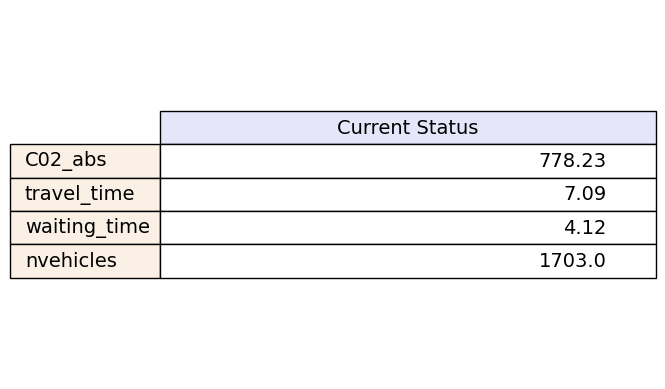

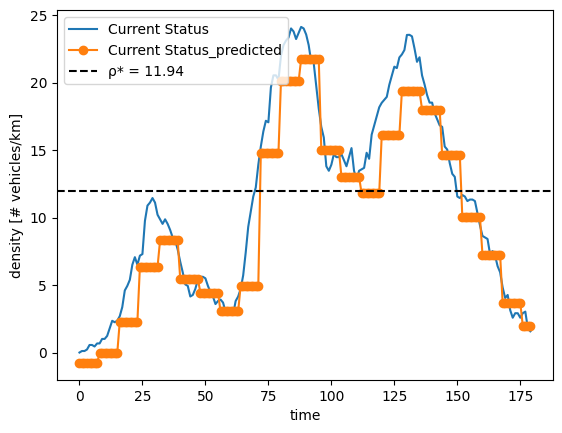

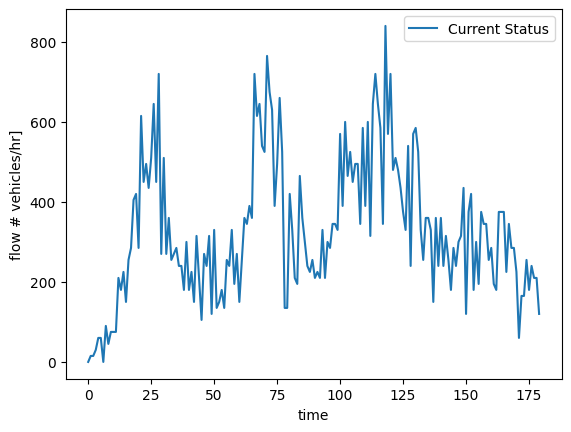

In [22]:
region = 'Region 4'
comM = Comparison([experimentMPC], ['Current Status'], region=region, rho=11.94)
comM.plot_metrics()

comM.plot_density()
comM.plot_flow()

In [23]:
# for r, rho in enumerate([5.7, 9.83, 10.63, 14.55]):
#     print(f"Region {r}")
#     region = f"Region {r}"
#     comM = Comparison([experimentMPC], ['Current'], region=region, rho=rho)
#     comM.plot_density(); com.plot_flow()

# comM.plot_input()

### DeePC Evaluation

In [ ]:
region = 'Region 4'
comD = Comparison([experimentDeePC], ['Current Status'], region=region, rho=11.94)
comD.plot_metrics()

comD.plot_density()
comD.plot_flow()
  

In [ ]:
# for r, rho in enumerate([5.7, 9.83, 10.63, 14.55]):
#     print(f"Region {r}")
#     region = f"Region {r}"
#     comD = Comparison([experimentDeePC], ['Current'], region=region, rho=rho)
#     comD.plot_density(); com.plot_flow()

comD.plot_input()

## Comparison

### MPC

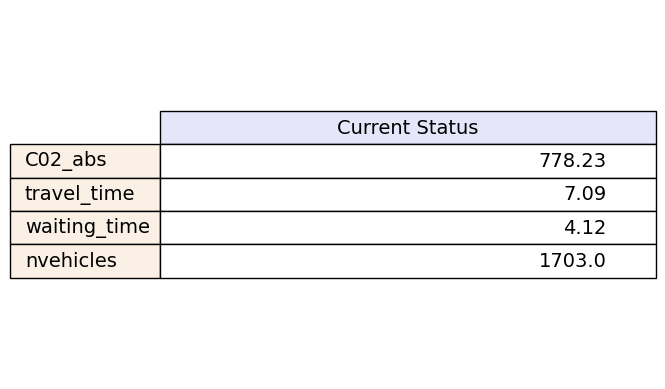

In [30]:
comM.plot_metrics()

### DeePC

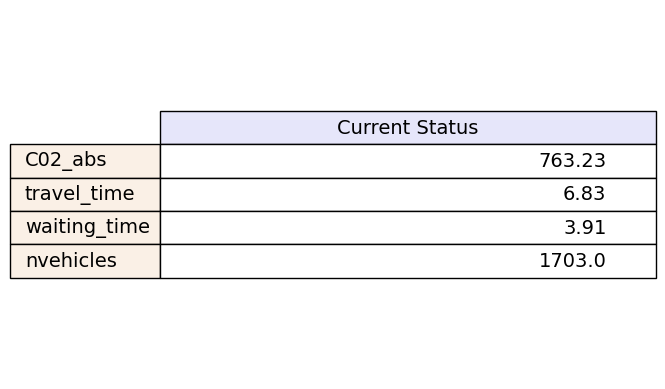

In [32]:
comD.plot_metrics()

# BONUS: TPC

Transient Predictive Controller

In [34]:
def _hankel_blocks(data: np.ndarray, depth: int) -> np.ndarray:
    """
    Construct a block-Hankel matrix with `depth` block-rows from multivariate `data`.
    
    Parameters
    ----------
    data : np.ndarray, shape (n_channels, T)
        The multivariate time series.
    depth : int
        Number of block-rows.
    
    Returns
    -------
    np.ndarray, shape (n_channels * depth, T - depth)
        The block-Hankel matrix.
    
    Raises
    ------
    ValueError
        If `depth` >= T.
    """
    n_channels, T = data.shape
    num_cols = T - depth
    if num_cols <= 0:
        raise ValueError(f"`depth` ({depth}) is too large for data length {T}")
    # Stack each lagged block along the first axis
    blocks = [data[:, i : i + num_cols] for i in range(depth)]
    return np.vstack(blocks)


def build_transient_predictors(
    U: np.ndarray,
    Y: np.ndarray,
    Lp: int,
    Lf: int
) -> list[np.ndarray]:
    """
    Estimate transient predictors Φ̂_{k} for k = Lp…Lp+Lf-1.

    Solves H1Y ≈ Φ [HpU; HpY] via least squares for each lag window.

    Parameters
    ----------
    U : np.ndarray, shape (m, T)
        Centered input signals.
    Y : np.ndarray, shape (p, T)
        Centered output signals.
    Lp : int
        Past window length.
    Lf : int
        Number of future steps to predict (horizon length).

    Returns
    -------
    List[np.ndarray]
        List of length Lf; the k-th element has shape (p, (m+p)*(Lp+k)).
    """
    m, T = U.shape
    p, _ = Y.shape
    phi_list = []

    for k in range(Lf):
        depth = Lp + k
        # Build block-Hankel matrices
        H_U = _hankel_blocks(U, depth)      # (m*depth, N)
        H_Y = _hankel_blocks(Y, depth)      # (p*depth, N)
        N = H_U.shape[1]                    # = T - depth

        # The “one-step shifted” outputs
        Y_shifted = Y[:, depth : depth + N]  # (p, N)

        # Concatenate inputs & outputs
        X = np.vstack((H_U, H_Y))           # ((m+p)*depth, N)

        # Solve for Φ: Xᵀ Φᵀ ≈ Y_shiftedᵀ  ⇒  Φᵀ = lstsq(Xᵀ, Y_shiftedᵀ)
        Phi_T, *_ = np.linalg.lstsq(X.T, Y_shifted.T, rcond=None)
        phi_list.append(Phi_T.T)             # (p, (m+p)*depth)

    return phi_list

In [48]:
class TPC_Controller(Controller):
    """
    Transient Predictive Controller (Moffat-Dörfler 2024)
    rewritten for *C-order* (row-major) vectorisation.
    """

    # --------------------------------------------------------------
    # 1. Constructor
    # --------------------------------------------------------------
    def __init__(self, actuators, params):
        super().__init__(actuators, params)
        self.name = "TPC-C"

        # --- Hyper-parameters -------------------------------------
        self.Lp = params.get("Lp", 20)                # past window
        self.Lf = params.get("Lf", 16)                # horizon length
        self.n  = 5                                   # #roads / regions

        self.Q  = np.diag(params.get("Q",  [0.05] * self.n))
        self.R  = np.diag(params.get("R",  [5e-4] * self.n))
        self.ul = np.full(self.n, params.get("u_min", 0.5))
        self.uu = np.full(self.n, params.get("u_max", 1.5))
        self.ref = params["rho_star"]                 # target densities

        # --- Offline identification ------------------------------
        io_path = "./dep/sumo_files/cocoCity/control/edge/io_data.csv"
        df = pd.read_csv(io_path, index_col=0)

        u_cols = [f"Speed limit factor for road {i}" for i in range(self.n)]
        y_cols = [f"Density in Region {i}"           for i in range(self.n)]

        U_raw = df[u_cols].to_numpy().T  
        Y_raw = df[y_cols].to_numpy().T  

        self.u_mean = U_raw.mean(axis=1, keepdims=True)
        self.y_mean = Y_raw.mean(axis=1, keepdims=True)

        Uc = U_raw - self.u_mean
        Yc = Y_raw - self.y_mean

        self.Phi = build_transient_predictors(Uc, Yc, self.Lp, self.Lf)

        # Quick sanity check
        T = U_raw.shape[1]
        free = T - (self.Lp + self.Lf)
        print(f"Φ identification: samples={free}, "
              f"params={2*self.n*(self.Lp+self.Lf)}, "
              f"ratio={free/(2*self.n*(self.Lp+self.Lf)):.2f}")

    # --------------------------------------------------------------
    # 2. Main control step
    # --------------------------------------------------------------
    def get_next_input(self, u_hist: np.ndarray, y_hist: np.ndarray):
        """
        Return the next actuation vector and a one-step density prediction.
        All vectorisations use order='C' explicitly.
        """
        m = self.n
        k = u_hist.shape[0]

        # ---------- Warm-up (not enough history yet) ---------------
        if k < self.Lp:
            y0 = (
                0
                if k == 0 or y_hist.size == 0
                else y_hist[-1]
            )
            return np.ones(m), y0

        # ---------- Centre past windows ----------------------------
        u_p = u_hist[-self.Lp:] - self.u_mean.T   # (Lp, m)
        y_p = y_hist[-self.Lp:] - self.y_mean.T   # (Lp, m)

        # ---------- Decision variables -----------------------------
        U = cp.Variable((self.Lf, m))
        Y = cp.Variable((self.Lf, m))

        constraints = [U >= self.ul, U <= self.uu]

        # ---------- TPC prediction constraints ---------------------
        for kf in range(self.Lf):
            # Past data (row-major flattening)
            feat_u = u_p.flatten(order="C")
            feat_y = y_p.flatten(order="C")

            # Add previously optimised future data
            if kf:
                feat_u = cp.hstack([feat_u,
                                    cp.reshape(U[:kf], (m*kf,), order="C")])
                feat_y = cp.hstack([feat_y,
                                    cp.reshape(Y[:kf], (m*kf,), order="C")])

            features = cp.hstack([feat_u, feat_y])
            constraints.append(Y[kf] == self.Phi[kf] @ features)

        # ---------- Quadratic cost (row-stacking) ------------------
        Qblk = np.kron(np.eye(self.Lf), self.Q)   # block-diag [Q … Q]
        Rblk = np.kron(np.eye(self.Lf), self.R)

        errY = cp.vec(Y, order="C") - np.tile(self.ref, self.Lf)
        errU = cp.vec(U - 1, order="C")
        cost = cp.quad_form(errY, Qblk) + cp.quad_form(errU, Rblk)

        # ---------- Solve -----------------------------------------
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver=cp.MOSEK, verbose=False)

        u_next = U.value[0]
        y_next = Y.value[0] + self.y_mean.flatten()
        return u_next, y_next

In [49]:
import numpy as np

class TPC_ControlSim(ControlSim):
    """
    Simulation wrapper that safely handles whether histories are stored
    as (T, m)/(T, p) or transposed as (m, T)/(p, T).
    """

    def compute_input(
        self,
        k: int,
        demand,
        controller: Controller,
        name: str,
        uData: np.ndarray,
        yData: np.ndarray,
        yPred,
        m: int,
        p: int,
        r,
        safety_low,
        safety_high
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        At time step k, extract the past k inputs/outputs (regardless of
        orientation), call the controller to get the next input/output,
        and ensure the shapes are (m,) and (p,) respectively.
        """
        u_hist = uData[:k, :]
        y_hist = yData[:, :k].T

        u_next, y_next = controller.get_next_input(u_hist, y_hist)

        # ——— Flatten and trim to correct dimensions
        u_next = np.ravel(u_next)[:m]
        y_next = np.ravel(y_next)[:p]

        return u_next, y_next


In [ ]:
# --------------------------------------------------------------------
# 4.  Plug-in & run
# --------------------------------------------------------------------
tpc_params = dict(
    Lp=4, Lf=2,
    Q=[0.5, 0.5, 0.5, 0.5, 0.45],
    R=[1]*5,
    rho_star=np.array([5.70, 9.83, 10.63, 14.55, 11.94]),
    u_min=0.5, u_max=1.5
)

dsl_task = DSL(taskparams, TPC_ControlSim)
experimentTPC = dsl_task.runtask(
    init_from_notebook=True,
    controller_class=TPC_Controller,
    controller_json=tpc_params
)

Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


In [ ]:
com = Comparison([experimentTPC], ['TPC'], region='Region 4'); 
com.plot_metrics()
com.plot_density()
com.plot_flow()
#com.plot_input()

In [58]:
import itertools, json, numpy as np
from collections import OrderedDict
from pprint import pprint

# --------------------------------------------------------------------
# 1.  DESIGN THE GRID
# --------------------------------------------------------------------
#   • Horizons      :  (Lp , Lf)
#   • Stage weights :  Q center (Region 4), Q other regions, R
#   • Φ̂ ridge λ    :  regularises least-squares when building predictors

horizon_pairs = [(4, 2), (4, 3)]      # add/trim as you like
Q_center_vals = [0.4, 0.5, 0.55]
Q_off_vals    = [0.4, 0.5, 0.6]                              # keep fixed or sweep
R_vals        = [1, 1.2, 0.8]

grid = list(itertools.product(
    horizon_pairs,
    Q_center_vals,
    Q_off_vals,
    R_vals
))
print(f"⏳  Sweeping {len(grid)} configurations …")

# --------------------------------------------------------------------
# 2.  HELPER – RUN ONE TPC EXPERIMENT AND RETURN (score, metrics)
# --------------------------------------------------------------------
def run_tpc_case(Lp, Lf, Qc, Qf, Rv):
    # ----- build controller param dict -----
    params = {
        'Lp': Lp,
        'Lf': Lf,
        'Q' : [Qf, Qf, Qf, Qf, Qc],
        'R' : [Rv]*5,
        'rho_star' : np.array([5.70, 9.83, 10.63, 14.55, 11.94]),
        'u_min'    : 0.5,
        'u_max'    : 1.5,
    }

    dsl = DSL(taskparams, TPC_ControlSim)        # same pattern as DeePC
    controller_class = TPC_Controller

    exp, metrics = None, None
    try:
        exp = dsl.runtask(
            init_from_notebook=True,
            controller_class=controller_class,
            controller_json=params
        )

        # ---- compute performance metric (same as your DeePC script) ----
        region = 'Region 4'
        comp = Comparison([exp], ['tmp'], region=region, rho=11.94)
        m_df = comp.met['comparison']
        metrics = m_df.iloc[:, 0]                # first (and only) column
        score   = metrics['travel_time']         # lower is better

        print(f"→ Lp={Lp},Lf={Lf},Qc={Qc},Qf={Qf},Rv={Rv}"
              f" ⇒ score {score:.3f}")
        return score, metrics

    except Exception as e:
        # infeasible solver, numerical fail, etc.
        print("  ✗ Infeasible or error:", e)
        return np.inf, None

    finally:
        # tidy up SUMO & TraCI ports
        if exp is not None and hasattr(exp, 'close'):
            exp.close()
        if hasattr(dsl, 'close'):
            dsl.close()

# --------------------------------------------------------------------
# 3.  RUN THE SWEEP
# --------------------------------------------------------------------
results = OrderedDict()
for (Lp, Lf), Qc, Qf, Rv in grid:
    key = dict(Lp=Lp, Lf=Lf, Qc=Qc, Qf=Qf, Rv=Rv)
    score, metrics = run_tpc_case(Lp, Lf, Qc, Qf, Rv)
    results[json.dumps(key)] = dict(score=score, metrics=metrics)

# --------------------------------------------------------------------
# 4.  PICK THE BEST CONFIGURATION
# --------------------------------------------------------------------
best_key     = min(results, key=lambda k: results[k]['score'])
best_cfg     = json.loads(best_key)
best_metrics = results[best_key]['metrics']

print("\n🏆  BEST TPC CONFIGURATION")
pprint(best_cfg, sort_dicts=False)
print("\n📊  METRICS FOR BEST CONFIG")
pprint(best_metrics, sort_dicts=False)


⏳  Sweeping 54 configurations …
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (2ms ~= 500.00*RT, ~295500.00UPS, TraCI: 82ms, vehicles TOT 1682 ACT 591 BUF
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.4,Rv=1 ⇒ score 10.480
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (2ms ~= 500.00*RT, ~196000.00UPS, TraCI: 217ms, vehicles TOT 1699 ACT 392 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.4,Rv=1.2 ⇒ score 8.930
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~435000.00UPS, TraCI: 181ms, vehicles TOT 1699 ACT 435 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.4,Rv=0.8 ⇒ score 8.570
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~147500.00UPS, TraCI: 178ms, vehicles TOT 1681 ACT 590 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.5,Rv=1 ⇒ score 10.470
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~191000.00UPS, TraCI: 115ms, vehicles TOT 1650 ACT 955 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.5,Rv=1.2 ⇒ score 16.670
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~196666.67UPS, TraCI: 181ms, vehicles TOT 1681 ACT 590 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.5,Rv=0.8 ⇒ score 10.470
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (2ms ~= 500.00*RT, ~233500.00UPS, TraCI: 181ms, vehicles TOT 1694 ACT 467 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.6,Rv=1 ⇒ score 9.200
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~196666.67UPS, TraCI: 212ms, vehicles TOT 1679 ACT 590 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.6,Rv=1.2 ⇒ score 10.720
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~192200.00UPS, TraCI: 254ms, vehicles TOT 1650 ACT 961 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.45,Qf=0.6,Rv=0.8 ⇒ score 16.800
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~238000.00UPS, TraCI: 85ms, vehicles TOT 1651 ACT 952 BUF
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.4,Rv=1 ⇒ score 16.560
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~344000.00UPS, TraCI: 191ms, vehicles TOT 1703 ACT 344 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.4,Rv=1.2 ⇒ score 8.940
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~175000.00UPS, TraCI: 200ms, vehicles TOT 1690 ACT 525 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.4,Rv=0.8 ⇒ score 9.810
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (2ms ~= 500.00*RT, ~162000.00UPS, TraCI: 193ms, vehicles TOT 1703 ACT 324 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.5,Rv=1 ⇒ score 8.900
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~176000.00UPS, TraCI: 197ms, vehicles TOT 1690 ACT 528 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.5,Rv=1.2 ⇒ score 9.840
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~190400.00UPS, TraCI: 94ms, vehicles TOT 1651 ACT 952 BUF
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.5,Rv=0.8 ⇒ score 16.560
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~234500.00UPS, TraCI: 144ms, vehicles TOT 1650 ACT 938 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.6,Rv=1 ⇒ score 16.300
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~238250.00UPS, TraCI: 65ms, vehicles TOT 1649 ACT 953 BUF
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.6,Rv=1.2 ⇒ score 16.640
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~238500.00UPS, TraCI: 249ms, vehicles TOT 1650 ACT 954 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.5,Qf=0.6,Rv=0.8 ⇒ score 16.650
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~190400.00UPS, TraCI: 84ms, vehicles TOT 1651 ACT 952 BUF
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.4,Rv=1 ⇒ score 16.560
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (6ms ~= 166.67*RT, ~158666.67UPS, TraCI: 171ms, vehicles TOT 1651 ACT 952 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.4,Rv=1.2 ⇒ score 16.560
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~196333.33UPS, TraCI: 139ms, vehicles TOT 1680 ACT 589 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.4,Rv=0.8 ⇒ score 10.470
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (2ms ~= 500.00*RT, ~294000.00UPS, TraCI: 219ms, vehicles TOT 1681 ACT 588 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.5,Rv=1 ⇒ score 10.450
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (2ms ~= 500.00*RT, ~217500.00UPS, TraCI: 225ms, vehicles TOT 1699 ACT 435 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.5,Rv=1.2 ⇒ score 8.570
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (0ms ?*RT. ?UPS, TraCI: 164ms, vehicles TOT 1703 ACT 92 BUF 0)              
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.5,Rv=0.8 ⇒ score 7.360
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (2ms ~= 500.00*RT, ~295500.00UPS, TraCI: 235ms, vehicles TOT 1682 ACT 591 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.6,Rv=1 ⇒ score 10.480
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (2ms ~= 500.00*RT, ~295000.00UPS, TraCI: 226ms, vehicles TOT 1681 ACT 590 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.6,Rv=1.2 ⇒ score 10.470
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=352, params=80, ratio=4.40


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~186600.00UPS, TraCI: 217ms, vehicles TOT 1649 ACT 933 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=6,Lf=2,Qc=0.55,Qf=0.6,Rv=0.8 ⇒ score 16.270
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~190800.00UPS, TraCI: 250ms, vehicles TOT 1651 ACT 954 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.4,Rv=1 ⇒ score 16.700
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~400000.00UPS, TraCI: 200ms, vehicles TOT 1699 ACT 400 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.4,Rv=1.2 ⇒ score 9.690
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~208000.00UPS, TraCI: 193ms, vehicles TOT 1655 ACT 832 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.4,Rv=0.8 ⇒ score 14.680
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (0ms ?*RT. ?UPS, TraCI: 153ms, vehicles TOT 1703 ACT 43 BUF 0)              
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.5,Rv=1 ⇒ score 6.150
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (7ms ~= 142.86*RT, ~133428.57UPS, TraCI: 329ms, vehicles TOT 1649 ACT 934 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.5,Rv=1.2 ⇒ score 16.360
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~214000.00UPS, TraCI: 232ms, vehicles TOT 1681 ACT 642 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.5,Rv=0.8 ⇒ score 11.890
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~505000.00UPS, TraCI: 191ms, vehicles TOT 1687 ACT 505 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.6,Rv=1 ⇒ score 9.340
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~308333.33UPS, TraCI: 244ms, vehicles TOT 1648 ACT 925 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.6,Rv=1.2 ⇒ score 16.140
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~218000.00UPS, TraCI: 217ms, vehicles TOT 1674 ACT 654 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.45,Qf=0.6,Rv=0.8 ⇒ score 11.640
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~239750.00UPS, TraCI: 273ms, vehicles TOT 1650 ACT 959 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.4,Rv=1 ⇒ score 16.770
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~236000.00UPS, TraCI: 288ms, vehicles TOT 1648 ACT 944 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.4,Rv=1.2 ⇒ score 16.540
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (6ms ~= 166.67*RT, ~159000.00UPS, TraCI: 329ms, vehicles TOT 1650 ACT 954 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.4,Rv=0.8 ⇒ score 16.710
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~192400.00UPS, TraCI: 294ms, vehicles TOT 1649 ACT 962 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.5,Rv=1 ⇒ score 16.870
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (6ms ~= 166.67*RT, ~159166.67UPS, TraCI: 272ms, vehicles TOT 1648 ACT 955 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.5,Rv=1.2 ⇒ score 16.710
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (4ms ~= 250.00*RT, ~235500.00UPS, TraCI: 230ms, vehicles TOT 1655 ACT 942 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.5,Rv=0.8 ⇒ score 16.320
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~191200.00UPS, TraCI: 318ms, vehicles TOT 1652 ACT 956 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.6,Rv=1 ⇒ score 16.660
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~180800.00UPS, TraCI: 306ms, vehicles TOT 1648 ACT 904 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.6,Rv=1.2 ⇒ score 16.080
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~139333.33UPS, TraCI: 182ms, vehicles TOT 1698 ACT 418 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.5,Qf=0.6,Rv=0.8 ⇒ score 8.160
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~400000.00UPS, TraCI: 127ms, vehicles TOT 1695 ACT 400 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.4,Rv=1 ⇒ score 8.880
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (8ms ~= 125.00*RT, ~119875.00UPS, TraCI: 120ms, vehicles TOT 1649 ACT 959 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.4,Rv=1.2 ⇒ score 16.770
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~193200.00UPS, TraCI: 314ms, vehicles TOT 1645 ACT 966 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.4,Rv=0.8 ⇒ score 17.190
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~308333.33UPS, TraCI: 277ms, vehicles TOT 1652 ACT 925 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.5,Rv=1 ⇒ score 16.200
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (7ms ~= 142.86*RT, ~114428.57UPS, TraCI: 266ms, vehicles TOT 1662 ACT 801 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.5,Rv=1.2 ⇒ score 13.850
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (5ms ~= 200.00*RT, ~190800.00UPS, TraCI: 255ms, vehicles TOT 1653 ACT 954 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.5,Rv=0.8 ⇒ score 16.640
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~224666.67UPS, TraCI: 227ms, vehicles TOT 1673 ACT 674 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.6,Rv=1 ⇒ score 11.860
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Step #400.00 (3ms ~= 333.33*RT, ~71666.67UPS, TraCI: 61ms, vehicles TOT 273 ACT 215 BUF 1)

/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~321000.00UPS, TraCI: 188ms, vehicles TOT 1700 ACT 321 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.6,Rv=1.2 ⇒ score 8.090
Running Simulation...
 Retrying in 1 seconds
Φ identification: samples=354, params=60, ratio=5.90


/opt/conda/envs/coco/lib/python3.13/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:200: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~466000.00UPS, TraCI: 176ms, vehicles TOT 1694 ACT 466 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!
→ Lp=4,Lf=2,Qc=0.55,Qf=0.6,Rv=0.8 ⇒ score 9.280

🏆  BEST TPC CONFIGURATION
{'Lp': 4, 'Lf': 2, 'Qc': 0.45, 'Qf': 0.5, 'Rv': 1}

📊  METRICS FOR BEST CONFIG
travel_time        6.15
waiting_time       3.34
C0_abs             1.77
C02_abs          704.18
HC_abs             0.01
PMx_abs            0.03
NOx_abs            0.26
fuel_abs         228.29
nvehicles       1703.00
Name: tmp, dtype: float64
